# Advanced DL and RL: Домашнее задание 2

Студент: **Панфилов Александр**

Группа: **MADE-DS-32**

### Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

**Пункт 1**

Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

**Пункт 2**

Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.


**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.


In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def Q_St_At_update(Q, St, At, Rt1, St1, a=0.01, g=1.0):
    if St: # Проверка на первый ход
        Q[St][At] += a * (Rt1 + g * np.max(Q.get(St1, 0)) - Q[St][At])

In [5]:
def choose_move(Q, s, empty_spaces, eps=0.1):
    number_of_moves = len(empty_spaces)
    move = np.random.randint(number_of_moves)
    
    if s in Q:  # знакомое состояние
        if np.random.random() > eps:  # проверка exploration
            move = np.argmax(Q[s])
    else:
        Q[s] = np.zeros(number_of_moves)

    return move, empty_spaces[move]

In [6]:
def conduct_Q_learning_episode(env, pi_1, pi_2, alpha=0.015, epsilon=0.3, gamma=1.0):
    env.reset()
    s, empty_spaces, a = env.getState()
    done = False
    pi_1_s,  pi_1_a = None, None
    pi_2_s, pi_2_a = None, None
    while not done:
        if a == 1:  # Ходят крестики
            move, move_aсtion = choose_move(pi_1, s, empty_spaces, eps=epsilon)
            state_new, reward, done, _ = env.step(move_aсtion)
            
            if reward == 1:
                pi_1[s][move] = 1
                
            # Обновим состояние для предыдущего хода (т.е для ноликов)
            Q_St_At_update(pi_2, pi_2_s, pi_2_a, -1*reward, state_new[0], a=alpha, g=gamma)   
            pi_1_s, pi_1_a = s, move
            
        elif a == -1:  # Ходят нолики
            move, move_aсtion = choose_move(pi_2, s, empty_spaces, eps=epsilon)  
            state_new, reward, done, _ = env.step(move_aсtion)
            
            if reward == -1:
                pi_2[s][move] = 1
                            
            # Обновим состояние для предыдущего хода (т.е для крестиков)
            Q_St_At_update(pi_1, pi_1_s, pi_1_a, reward, state_new[0], a=alpha, g=gamma)
            pi_2_s, pi_2_a = s, move
            
        s, empty_spaces, a = state_new

In [7]:
def run_experiment(env, pi_1, pi_2, game_type=1):
    env.reset()
    s, empty_spaces, a = env.getState()
    done = False
    while not done:
        if game_type == 1: 
            Q = pi_1
        else:
            Q = pi_2
        if game_type == a:
            eps = 0
        else:
            eps = 1
        move, move_aсtion = choose_move(Q, s, empty_spaces, eps=eps)
        state, reward, done, _ = env.step(move_aсtion)
        s, empty_spaces, a = state
    return reward

def plot_stats(indicies, loses, draws, wins, mode=1):
    plt.figure(figsize=(12, 8))
    plt.plot(indicies, loses, label="Процент проигрышей", linewidth=1.5)
    plt.plot(indicies, draws, label="Процент ничьих", linewidth=1.5)
    plt.plot(indicies, wins, label="Процент побед", linewidth=1.5)
    plt.xlim(left=1)
    plt.xlabel("Количество сыгранных эпизодов")
    plt.ylabel("%")
    if mode == 1:
        plt.title(f"Средние для игры за крестики против случайно стратегии после эпизода {i}")
    else:
        plt.title(f"Средние для игры за нолики против случайно стратегии после эпизода {i}")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Пункт 1

Поле 3 х 3, 3 в ряд

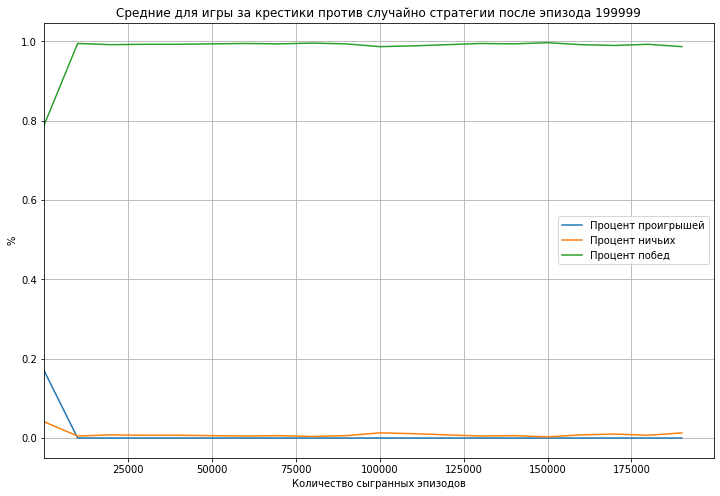

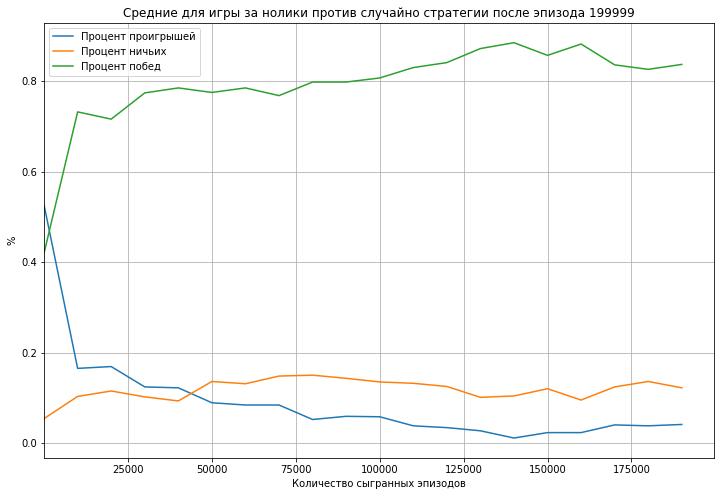

In [8]:
pi_1_3, pi_2_3 = dict(), dict()

env = TicTacToe(3, 3, 3)
indicies = []
crosses, noughts = [[], [], []], [[], [], []]
test_run = 1000

for i in range(200000):
    conduct_Q_learning_episode(env, pi_1_3, pi_2_3, epsilon=0.3)
    if i % 10000 == 0:
        crosses_dict = {-1: 0, 1: 0, 0: 0}
        noughts_dict = {-1: 0, 1: 0, 0: 0}
        experiment = {1: crosses_dict, -1: noughts_dict}
        for _ in range(test_run):
            experiment[-1][-1*run_experiment(env, pi_1_3, pi_2_3, game_type=-1)] += 1
            experiment[1][run_experiment(env, pi_1_3, pi_2_3, game_type=1)] += 1
        
        for k in range(-1, 2):
            crosses[k+1].append(experiment[1][k] / test_run)
            noughts[k+1].append(experiment[-1][k] / test_run)            
        
        indicies.append(i)
        plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
        plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)
        clear_output(wait=True)
        
plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)

#### Пункт 2

Поля (4 х 4, 4 в ряд) и (5 х 5, 5 в ряд)

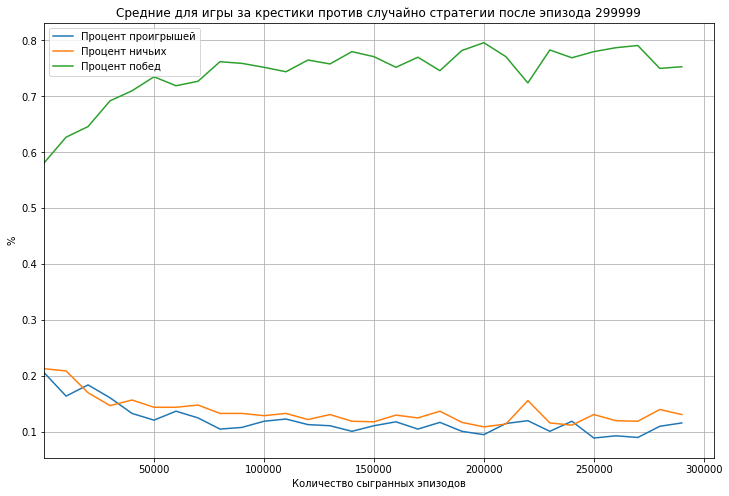

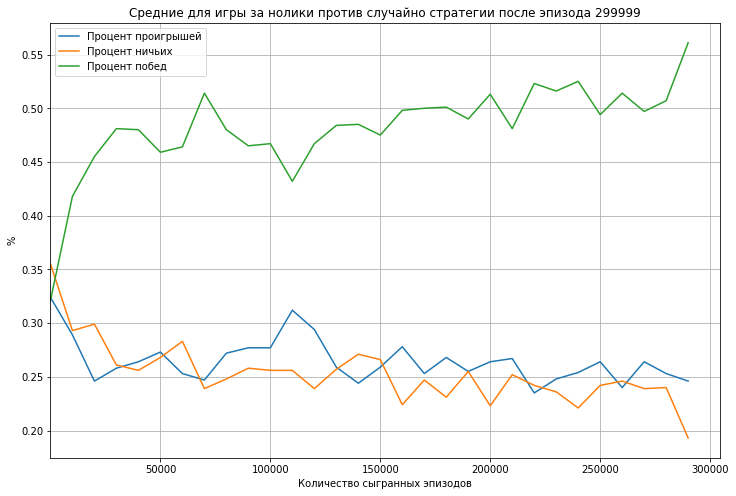

In [9]:
pi_1_4, pi_2_4 = dict(), dict()

env = TicTacToe(4, 4, 4)
indicies = []
crosses, noughts = [[], [], []], [[], [], []]

test_run = 1000
for i in range(300000):
    conduct_Q_learning_episode(env, pi_1_4, pi_2_4, epsilon=0.3)
    if i % 10000 == 0:
        crosses_dict = {-1: 0, 1: 0, 0: 0}
        noughts_dict = {-1: 0, 1: 0, 0: 0}
        experiment = {1: crosses_dict, -1: noughts_dict}
        for _ in range(test_run):
            experiment[-1][-1*run_experiment(env, pi_1_4, pi_2_4, game_type=-1)] += 1
            experiment[1][run_experiment(env, pi_1_4, pi_2_4, game_type=1)] += 1
        
        for k in range(-1, 2):
            crosses[k+1].append(experiment[1][k] / test_run)
            noughts[k+1].append(experiment[-1][k] / test_run)            
        
        indicies.append(i)
        plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
        plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)
        clear_output(wait=True)
        
plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)

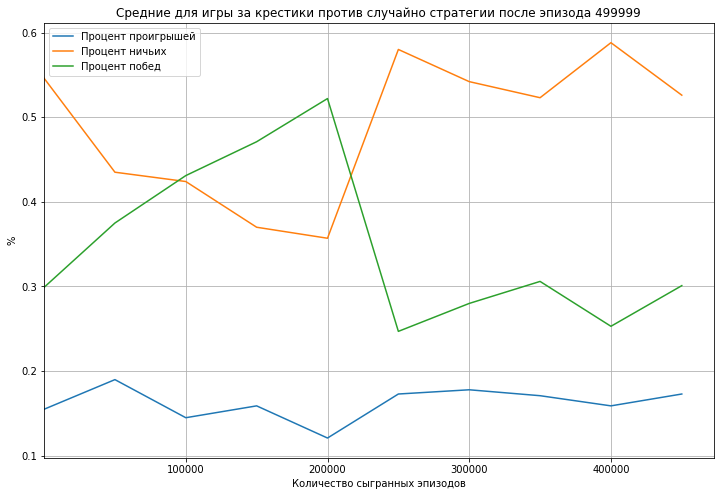

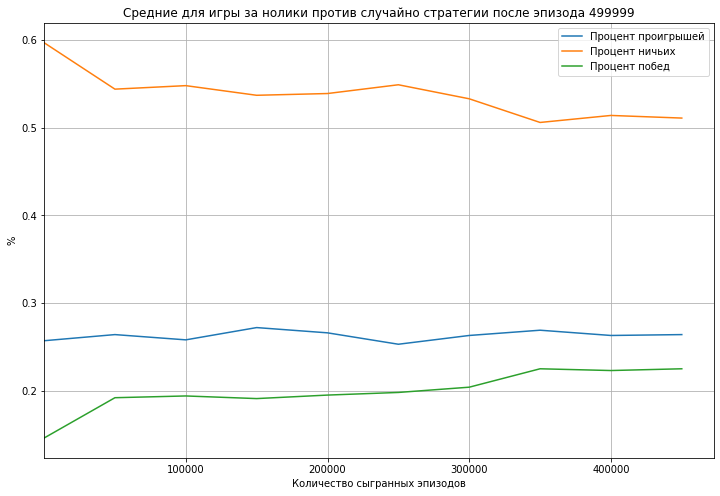

In [10]:
pi_1_5, pi_2_5 = dict(), dict()

env = TicTacToe(5, 5, 5)
indicies = []
crosses, noughts = [[], [], []], [[], [], []]

test_run = 1000
for i in range(500000):
    conduct_Q_learning_episode(env, pi_1_5, pi_2_5, epsilon=0.35)
    if i % 50000 == 0:
        crosses_dict = {-1: 0, 1: 0, 0: 0}
        noughts_dict = {-1: 0, 1: 0, 0: 0}
        experiment = {1: crosses_dict, -1: noughts_dict}
        for _ in range(test_run):
            experiment[-1][-1*run_experiment(env, pi_1_5, pi_2_5, game_type=-1)] += 1
            experiment[1][run_experiment(env, pi_1_5, pi_2_5, game_type=1)] += 1
        
        for k in range(-1, 2):
            crosses[k+1].append(experiment[1][k] / test_run)
            noughts[k+1].append(experiment[-1][k] / test_run)            
        
        indicies.append(i)
        plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
        plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)
        clear_output(wait=True)
        
plot_stats(indicies, crosses[0], crosses[1], crosses[2], mode=1)
plot_stats(indicies, noughts[0], noughts[1], noughts[2], mode=0)

### Часть вторая: добавим нейронных сетей

Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

**Пункт 3**

Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

**Пункт 4**

Реализуйте Double DQN и/или Dueling DQN.


In [185]:
# Ниже я пытаюсь переделать pytorch гайд по DQN под нашу задачу
# По состоянию на 13.12.2020 - безуспешно
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import namedtuple
from itertools import count
import random

In [192]:
# Сеть предскзаывает, в какую клетку сходить 
class DQN(nn.Module):
    def calculate_lin_size(self):
        size = self.conv3(self.conv2(self.conv1(torch.rand(1, 1, 3, 3)))).size()
        m = 1
        for i in size:
            m *= i
        return int(m) 
    
    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, padding=2, kernel_size=2)
        self.conv2 = nn.Conv2d(16, 32, padding=1, kernel_size=2)
        self.conv3 = nn.Conv2d(32, 32, padding=1, kernel_size=2)  
        lin_sz = self.calculate_lin_size()
        self.head = nn.Linear(lin_sz, h*w)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        return self.head(x.view(x.size(0), -1))


In [193]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [194]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 128
GAMMA = 1
EPS = 0.3
TARGET_UPDATE = 10

desk_size = 3
env = TicTacToe(desk_sz, desk_sz, desk_sz)

policy_net = DQN(desk_sz, desk_sz).to(device)
target_net = DQN(desk_sz, desk_sz).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


def select_action(state, empty_spaces):
    sample = np.random.random()
    if sample > EPS:
        with torch.no_grad():
            for action in np.argsort(policy_net(state).cpu().detach().numpy())[0][::-1]:
                row = action // desk_size
                col = action - row*desk_size
                move = (row, col)
                if move in empty_spaces:
                    return move
    else:
        move = empty_spaces[np.random.randint(len(empty_spaces))]
        return move



In [195]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                         if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat([torch.Tensor([i]) for i in batch.action])
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


In [197]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    s, empty_spaces, a = env.getState()
    
    state = torch.Tensor(env.board).to(device).unsqueeze(0).unsqueeze(0)
    done = False
    while not done:
        # Select and perform an action
        action = select_action(state, empty_spaces)
    
        state_tuple_new, reward, done_d, _ = env.step(action)
        if not done_d:
            _, empty_spaces, _ = state_tuple_new
            move = empty_spaces[np.random.randint(len(empty_spaces))]
            state_tuple_new, enemy_reward, done, _ = env.step(move)
            _, empty_spaces, _ = state_tuple_new
            if enemy_reward == -1:
                reward = -1
            reward = torch.tensor([reward], device=device)
        

        if not done:
            next_state = torch.Tensor(env.board).to(device).unsqueeze(0).unsqueeze(0)
        else:
            next_state = None
        # Store the transition in memory
        memory.push(state, (action[0]*desk_size + action[1]), next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
       
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())


TypeError: expected Tensor as element 0 in argument 0, but got int

Выводы:

1. В пункте 1 и 2 стратегии крестиков со временем улучшаются, а для улучшения игры за нолики нужно побольше времени
2. Не садится за такую домашку в выходные перед делайном. Баг с ReplayMemory победить не получилось (дедлайн через 15 мин)